In [355]:
import cv2
import numpy as np
import os, sys
from matplotlib import collections as mc
from matplotlib import pyplot as plt


In [144]:
class union_find():
    def __init__(self, n_vertic):
        self._parent = [-1 for _ in range(n_vertic)]
        self._size = [1 for _ in range(n_vertic)]
        self._rank = [0 for _ in range(n_vertic)]
        self.n_vertic = n_vertic
        
    def join(self, a, b):
        ra = self.find_root(a)
        rb = self.find_root(b)
        
        if ra == rb:
            return
        
        if self._rank[ra] <=  self._rank[rb]:
            self._parent[ra] = rb
            self._size[rb] += self._size[ra]
        else:
            self._parent[rb] = ra
            self._size[ra] += self._size[rb]
        if self._rank[ra] ==  self._rank[rb]:
            self._rank[rb] += 1
            
    
    def find_root(self, x):
        if self._parent[x] == -1:
            return x
        
        temp = x
        while self._parent[temp] != -1:
            temp = self._parent[temp]
        self._parent[x] = temp
        
        return temp
    
    def size(self, x):
        root = self.find_root(x)
        return self._size[root]
    
    def parent(self):
        return self._parent
    
    def num_set(self):
        count = 0
        for p in self._parent:
            if p == -1:
                count += 1
        return count
    
    def print_set(self):
        for i, r in enumerate(self._parent):
            if r == -1:
                print("Root {}, size {}, rank {}".format(i, self._size[i], self._rank[i]))
                
                

In [352]:
def read_image(fpath):
    return cv2.imread(fpath, cv2.IMREAD_COLOR)

def get_distance(image_arr, record_vertic = False):
    """
    Build graph. A Pixel mimics a graph node, the distance messure between two nodes mimics an edge. Every node
    only consider the surounding 8 nodes as neighbors to form edges.
    Input:
        image_arr: a 2D array representing a channel
        record_vertic: choose whether to return the 2D coordinates with respect to an edge
    return:
        1. numpy array of edges
        2. numpy array of corresponding coordinates. Effective when record_vertic=True.
    """
    m, n = image_arr.shape
    dirs = [[-1, 1], [0, 1], [1, 1], [1, 0]]
    dist = []
    coord = []
    for x in range(m):
        for y in range(n):
            for d in dirs:
                nx = x + d[0]
                ny = y + d[1]
                if 0<=nx<m and 0<=ny<n:
                    dist.append(abs(image_arr[x, y] - image_arr[nx, ny]))
                    if record_vertic:
                        coord.append([x*n+y, nx*n+ny])
                        
    return np.array(dist), np.array(coord)

def get_threshold(K, size):
    """
    Correction of internal distance.
    Input:
        K: a constant
        size: the size of the given set
    return:
        a scalar calculated by K/size
    """
    return K/size

def merge(image, K=100, min_size=50, filter_size=(3,3), sigma=0.5, high_recall=True, all_channel=True, verb=True):
    """
    Apply gassian smoothing filter. Use union-and-find data structure to group pixels. Depending on the setting
    of all_channel, either use all R, G, B channel or sum of squared values as clustering criteria.
    If the current edge(on all channels or SS value) is no greater than the internal distance
    (all channels or SS value) of each of the two candidate groups, merge the two groups.
    Input:
        K: same constant to calculate the internal distance
        min_size: the minimum number of pixels to form a group
        filter_size: Gaussian filter kernal size
        sigma: the standard deviation of gaussian filter
        high_recall: high recall mode uses mininum internal distance as metric, it tends not to cluster and 
        leads to more segments. If high_recal is not set, it ues max interval distance, making it easier to
        cluster.
        all_channel: if use all three channel 
    return:
        A union-find data structure that contains the grouping information.
    """
    image = cv2.GaussianBlur(image, filter_size, sigma)
    edges = []
    n_chan = 0
    n_vertic = image.shape[0]*image.shape[1]
    if len(image.shape) == 2:
        edges.append(get_distance(image))
        n_chan = 1
    elif len(image.shape) == 3:
        n_chan = 3
        for i in range(image.shape[2]):
            if i == 0:
                e, vertices = get_distance(image[:, :, i], record_vertic=True)
            else:
                e, _ = get_distance(image[:, :, i], record_vertic=False)
            edges.append(e)       
        
    edges = np.stack(edges, axis=1)
    index = [x for x in range(len(edges))]
    if all_channel: # edge and inter_diff all have three columns
        index.sort(key = lambda x: np.sum(edges[x, :]))
        inter_diff = np.ones((n_vertic, n_chan)) * get_threshold(K, 1)
    else: # edge and inter_diff only record sum of squared value of three channels
        edges = np.sqrt(np.sum(np.square(edges), axis=1))
        index.sort(key = lambda x: edges[x])
        inter_diff = np.ones((n_vertic, )) * get_threshold(K, 1)
    
    if verb:
        print("Number of edges and vertices: {}, {}".format(edges.shape[0], inter_diff.shape[0]))
    
    union_set = union_find(n_vertic)
    for i in index:
        edge = edges[i] # shape = (n_chan, ) or (1, ) depends on argument all_channel
        ru = union_set.find_root(vertices[i, 0])
        rv = union_set.find_root(vertices[i, 1])
        
        if ru == rv:
            continue
            
        if np.all(edge <= inter_diff[ru]) and np.all(edge <= inter_diff[rv]):
            du = inter_diff[ru] - get_threshold(K, union_set.size(ru))
            dv = inter_diff[rv] - get_threshold(K, union_set.size(rv))
            union_set.join(ru, rv)
            ru = union_set.find_root(ru)
            
            if high_recall:
                # use the minimum value among du, dv, edge
                dd = np.min(np.stack([du, dv, edge], axis=0), axis=0)
            else:
                dd = np.max(np.stack([du, dv, edge], axis=0), axis=0)
                
            inter_diff[ru] = dd + get_threshold(K, union_set.size(ru))
            
    if min_size > 0:
        for i in index:
            ru = union_set.find_root(vertices[i, 0])
            rv = union_set.find_root(vertices[i, 1])
            if ru != rv and (union_set.size(ru) < min_size or union_set.size(rv) < min_size):
                union_set.join(ru, rv)
    
    print("Total number of segments: ", np.where(np.array(segments.parent())==-1)[0].shape[0])
    
    return union_set


def color_generator(bins):
    """
    A random color generator.
    Input:
        bins: bin number for discretizing color range
    return:
        a numpy array containing R, G, B value
    """
    interval = 255 // bins
    color = np.arange(0, 256, interval)
    n = len(color)
    while True:
        idx = np.random.randint(0, n, 3)
        yield np.array(color[idx])

def render(union_set, image_arr, color_bins=10):
    """
    Render image based on segmentation results
    Input:
        union_set: union-find data structure that contains segementation information
        image_arr: RGB image numpy array
        color_bins: bin number to discretize color range
    return:
        Rendered RGB image
    """
    m, n, c = image_arr.shape
    image_rend = np.copy(image_arr)
    
    roots_color = {}
    gen = color_generator(color_bins)
    for i in range(union_set.n_vertic):
        root = union_set.find_root(i)
        x, y = int(i/n), int(i%n)
        
        if root not in roots_color:
            roots_color[root] = next(gen)
        image_rend[x, y, :] = roots_color[root]
        
    return image_rend
            
        

In [353]:
# Read images
img = cv2.imread("small1.jpg").astype(float)
segments = merge(img, K=200, min_size=50, high_recall=True, all_channel=False, verb=True)


Number of edges and vertices: 273228, 68704
Total number of segments:  284


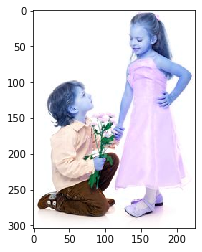

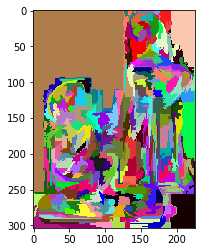

In [354]:
plt.imshow(img/255)
plt.show()

img_render = render(segments, img)
plt.imshow(img_render/255)
plt.show()